In [1]:
import math
import random
import glob
import os
import numpy as np

import cv2
import numbers
import collections

import torch
from torch.utils import data

from utils import resize_image, load_image, save_image

# default list of interpolations
_DEFAULT_INTERPOLATIONS = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC]

D:\Anaconda\envs\cs39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#################################################################################
# These are helper functions or functions for demonstration
# You won't need to modify them
#################################################################################

class Compose(object):
  """Composes several transforms together.

  Args:
      transforms (list of ``Transform`` objects): list of transforms to compose.

  Example:
      >>> Compose([
      >>>     Scale(320),
      >>>     RandomSizedCrop(224),
      >>> ])
  """
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, img):
    for t in self.transforms:
        img = t(img)
    return img

  def __repr__(self):
    repr_str = ""
    for t in self.transforms:
      repr_str += t.__repr__() + '\n'
    return repr_str


class RandomHorizontalFlip(object):
  """Horizontally flip the given numpy array randomly
     (with a probability of 0.5).
  """
  def __call__(self, img):
    """
    Args:
        img (numpy array): Image to be flipped.

    Returns:
        numpy array: Randomly flipped image
    """
    if random.random() < 0.5:
      img = cv2.flip(img, 1)
      return img
    return img

  def __repr__(self):
    return "Random Horizontal Flip"

#################################################################################
# You will need to fill in the missing code in these classes
#################################################################################

In [3]:
class Scale(object):
  """Rescale the input numpy array to the given size.

  Args:
      size (sequence or int): Desired output size. If size is a sequence like
          (w, h), output size will be matched to this. If size is an int,
          smaller edge of the image will be matched to this number.
          i.e, if height > width, then image will be rescaled to
          (size, size * height / width)

      interpolations (list of int, optional): Desired interpolation.
      Default is ``CV2.INTER_NEAREST|CV2.INTER_LINEAR|CV2.INTER_CUBIC``
      Pass None during testing: always use CV2.INTER_LINEAR
  """
  def __init__(self, size, interpolations=_DEFAULT_INTERPOLATIONS):
    assert (isinstance(size, int)
            or (isinstance(size, collections.Iterable)
                and len(size) == 2)
           )
    self.size = size
    # use bilinear if interpolation is not specified
    if interpolations is None:
        interpolations = [cv2.INTER_LINEAR]
    assert isinstance(interpolations, collections.Iterable)
    self.interpolations = interpolations

  def __call__(self, img):
    """
    Args:
        img (numpy array): Image to be scaled.

    Returns:
        numpy array: Rescaled image
    """
    # sample interpolation method
    interpolation = random.sample(self.interpolations, 1)[0]

    # scale the image
    if isinstance(self.size, int):
        w = img.shape[1]
        h = img.shape[0]
        if w < h:
            h_1 = self.size
            w_1 = int(self.size * h / w)
            img = resize_image(img, [w_1,h_1], interpolation)
        else:
            h_1 = self.size
            w_1 = int(self.size * w / h)
            img = resize_image(img, [w_1,h_1], interpolation)
        
        return img
    else:
        img = resize_image(img, self.size, interpolation)
        return img


  def __repr__(self):
    if isinstance(self.size, int):
        target_size = (self.size, self.size)
    else:
        target_size = self.size
    return "Scale [Exact Size ({:d}, {:d})]".format(target_size[0], target_size[1])



In [4]:
class RandomSizedCrop(object):
  """Crop the given numpy array to random area and aspect ratio.

  A crop of random area of the original size with a random aspect ratio is made.
  This crop is finally resized to a fixed given size. This is widely used
  as data augmentation for training image classification models.

  Args:
      size (sequence or int): size of target image. If size is a sequence like
          (w, h), output size will be matched to this. If size is an int,
          output size will be (size, size).
      interpolations (list of int, optional): Desired interpolation.
      Default is ``CV2.INTER_NEAREST|CV2.INTER_LINEAR|CV2.INTER_CUBIC``
      area_range (list of int): range of the areas to sample from
      ratio_range (list of int): range of aspect ratio to sample from
      num_trials (int): number of sampling trials
  """

  def __init__(self, size, interpolations=_DEFAULT_INTERPOLATIONS,
               area_range=(0.25, 1.0), ratio_range=(0.8, 1.2), num_trials=10):
    self.size = size
    if interpolations is None:
        interpolations = [cv2.INTER_LINEAR]
    assert isinstance(interpolations, collections.Iterable)
    self.interpolations = interpolations
    self.num_trials = int(num_trials)
    self.area_range = area_range
    self.ratio_range = ratio_range

  def __call__(self, img):
    # sample interpolation method
    interpolation = random.sample(self.interpolations, 1)[0]
    flag_corp = True
    for attempt in range(self.num_trials):

      # sample target area / aspect ratio from area range and ratio range
        area = img.shape[0] * img.shape[1]
        target_area = random.uniform(self.area_range[0], self.area_range[1]) * area
        aspect_ratio = random.uniform(self.ratio_range[0], self.ratio_range[1])
        
        target_w = int(math.sqrt(target_area / aspect_ratio))
        target_h = int(target_area / target_w)
        if target_w > img.shape[1]:
            continue
        elif target_h > img.shape[0]:
            continue
        else:
            x_1=np.random.randint(img.shape[1]-target_w)
            x_2=x_1+target_w
            y_1=np.random.randint(img.shape[0]-target_h)
            y_2=y_1+target_h
            img = img[y_1:y_2,x_1:x_2]
            if isinstance(self.size,int):
                target_size=int(self.size)
                img=resize_image(img, [target_size,target_size], interpolation)
            else:
                img=resize_image(img,[self.size[0],self.size[1]],interpolation)
            
            flag_corp=False
            return img

      #################################################################################
      # compute the width and height
      # note that there are two possibilities
      # crop the image and resize to output size

    # Fall back
    if flag_corp:
        if isinstance(self.size, int):
            im_scale = Scale(self.size, interpolations=self.interpolations)
            img = im_scale(img)
          #################################################################################
            wid=img.shape[1]
            hei=img.shape[0]
            center_point_w=int(wid/2)
            center_point_h=int(hei/2)
            bias=int(self.size/2)
            x_1=center_point_w-bias
            x_2=center_point_w+bias
            y_1=center_point_h-bias
            y_2=center_point_h+bias
            img = img[y_1:y_2 , x_1:x_2]
          #################################################################################
          # with a square sized output, the default is to crop the patch in the center
          # (after all trials fail)
            return img
        else:
          # with a pre-specified output size, the default crop is the image itself
            im_scale = Scale(self.size, interpolations=self.interpolations)
            img = im_scale(img)
            return img

  def __repr__(self):
    if isinstance(self.size, int):
      target_size = (self.size, self.size)
    else:
      target_size = self.size
    return "Random Crop" + \
           "[Size ({:d}, {:d}); Area {:.2f} - {:.2f}; Ratio {:.2f} - {:.2f}]".format(
            target_size[0], target_size[1],
            self.area_range[0], self.area_range[1],
            self.ratio_range[0], self.ratio_range[1])



In [5]:
class RandomColor(object):
  """Perturb color channels of a given image
  Sample alpha in the range of (-r, r) and multiply 1 + alpha to a color channel.
  The sampling is done independently for each channel.

  Args:
      color_range (float): range of color jitter ratio (-r ~ +r) max r = 1.0
  """
  def __init__(self, color_range):
    self.color_range = color_range

  def __call__(self, img):
    #################################################################################
    threshold=1
    r_r=random.uniform(1-self.color_range, 1+self.color_range)
    r_g=random.uniform(1-self.color_range, 1+self.color_range)
    r_b=random.uniform(1-self.color_range, 1+self.color_range)
    r,g,b=cv2.split(img)
    r=r*r_r/255
    #r=np.around(r)
    r=r.astype("float")
    r[r>threshold]=1

    b=b*r_b/255
    #b=np.around(b)
    b=b.astype("float")
    b[b>threshold]=1

    g=g*r_g/255
    #g=np.around(g)
    g=g.astype("float")
    g[g>threshold]=1
    img=cv2.merge((r,g,b))
    #################################################################################
    return img

  def __repr__(self):
    return "Random Color [Range {:.2f} - {:.2f}]".format(
            1-self.color_range, 1+self.color_range)



In [6]:
class RandomRotate(object):
  """Rotate the given numpy array (around the image center) by a random degree.

  Args:
      degree_range (float): range of degree (-d ~ +d)
  """
  def __init__(self, degree_range, interpolations=_DEFAULT_INTERPOLATIONS):
    self.degree_range = degree_range
    if interpolations is None:
      interpolations = [cv2.INTER_LINEAR]
    assert isinstance(interpolations, collections.Iterable)
    self.interpolations = interpolations

  def __call__(self, img):
    # sample interpolation method
    interpolation = random.sample(self.interpolations, 1)[0]
    # sample rotation
    degree = random.uniform(-self.degree_range, self.degree_range)
    # ignore small rotations
    if np.abs(degree) <= 1.0:
        return img

    #################################################################################
    w = int(img.shape[1])
    h = int(img.shape[0])
    theta=cv2.getRotationMatrix2D((w/2,h/2),degree,1)
    img=cv2.warpAffine(img,theta,(w,h))
    #################################################################################
    # get the max rectangular within the rotated image
    center_point_w=int(w/2)
    center_point_h=int(h/2)
    tanthe=abs(math.tan(math.pi / 180 * degree))
    costhe=abs(math.cos(math.pi / 180 * degree))
    target_wid=(w - h * tanthe)/((1 - pow(tanthe,2)) * costhe)
    target_hei=(h - w * tanthe)/((1 - pow(tanthe,2)) * costhe)
    
    x_1=center_point_w-int(target_wid/2)
    x_2=center_point_w+int(target_wid/2)
    y_1=center_point_h-int(target_hei/2)
    y_2=center_point_h+int(target_hei/2)
    img = img[y_1:y_2 , x_1:x_2]
    
    return img

  def __repr__(self):
    return "Random Rotation [Range {:.2f} - {:.2f} Degree]".format(
            -self.degree_range, self.degree_range)



In [18]:
#################################################################################
# Additional helper functions. No need to modify.
#################################################################################
class ToTensor(object):
  """Convert a ``numpy.ndarray`` image to tensor.
  Converts a numpy.ndarray (H x W x C) image in the range
  [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
  """
  def __call__(self, img):
    assert isinstance(img, np.ndarray)
    # convert image to tensor
    assert (img.ndim > 1) and (img.ndim <= 3)
    if img.ndim == 2:
        img = img[:, :, None]
        tensor_img = torch.from_numpy(np.ascontiguousarray(
        img.transpose((2, 0, 1))))
    if img.ndim == 3:
        tensor_img = torch.from_numpy(np.ascontiguousarray(
        img.transpose((2, 0, 1))))
    # backward compatibility
    if isinstance(tensor_img, torch.ByteTensor):
        return tensor_img.float().div(255.0)
    else:
        return tensor_img


class SimpleDataset(data.Dataset):
  """
  A simple dataset using PyTorch dataloader
  """
  def __init__(self, root_folder, file_ext, transforms=None):
    # root folder, split
    self.root_folder = root_folder
    self.transforms = transforms
    self.file_ext = file_ext

    # load all labels
    file_list = glob.glob(os.path.join(root_folder, '*.{:s}'.format(file_ext)))
    self.file_list = file_list

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    # load img and label (from file name)
    filename = self.file_list[index]
    img = load_image(filename)
    label = os.path.basename(filename)
    label = label.rstrip('.{:s}'.format(self.file_ext))
    # apply data augmentation
    if self.transforms is not None:
        
        img  = self.transforms(img)
    return img, label

In [26]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# set up the transforms (make sure you convert numpy array to pytorch tensor)
transforms = []
transforms.append(Scale(320))
transforms.append(RandomHorizontalFlip())
transforms.append(RandomColor(0.15))
transforms.append(RandomRotate(30))
#transforms.append(RandomSizedCrop(144))
#transforms.append(ToTensor())
comp_transforms = Compose(transforms)
print(comp_transforms)

Scale [Exact Size (320, 320)]
Random Horizontal Flip
Random Color [Range 0.85 - 1.15]
Random Rotation [Range -30.00 - 30.00 Degree]



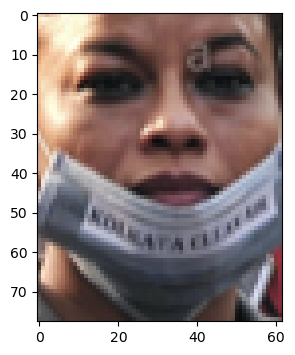

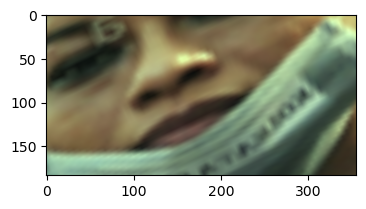

In [34]:
image1 = load_image('../data/mak.png')
transformed_image1 = comp_transforms(image1)

# let's take a look at the results!
plt.figure(figsize=(4,4)); plt.imshow(image1);
plt.figure(figsize=(4,4)); plt.imshow(transformed_image1);


In [9]:
# let us try a toy dataset
dataset = SimpleDataset('../data', file_ext='bmp', transforms=comp_transforms)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

# loop over the data set
for batch_idx, (imgs, labels) in enumerate(data_loader):
    print(imgs.shape)
    print(labels)
    for img_idx, img in enumerate(imgs):
        vis_img = img.permute(1, 2, 0).numpy()
        vis_img = (255 * vis_img).astype(np.uint8)
        plt.figure(); plt.imshow(vis_img)
        #save_image('../results/loader_outputs_{:d}-{:d}.jpg'.format(batch_idx, img_idx), vis_img)

RuntimeError: stack expects each tensor to be equal size, but got [3, 304, 348] at entry 0 and [3, 320, 390] at entry 1

In [ ]:
img = load_image('../data/dog.bmp')

img=RandomRotate(60)(img)
#img=np.array(img)
plt.imshow(img)
#save_image('../results/outputs_3.2.4_3.jpg', img)